
## Problem Statement : Forecasting Avocado Sale Prices in USA


### Content

   
   
   The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. 

   The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

1. Date - The date of the observation
2. AveragePrice - the average price of a single avocado
3. type - conventional or organic
4. year - the year
5. Region - the city or region of the observation
6. Total Volume - Total number of avocados sold
7. 4046 - Total number of avocados with PLU 4046 sold
8. 4225 - Total number of avocados with PLU 4225 sold
9. 4770 - Total number of avocados with PLU 4770 sold



### Importing Libraries and Reading Data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from fbprophet import Prophet

df = pd.read_csv('avocado.csv')

df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


- Prophet is open source library released by Facebook’s Core Data Science team for python forecasting purposes.

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

- Prophet works best with time series that have strong seasonal effects and several seasons of historical data.

- For more information, please check this out: https://research.fb.com/prophet-forecasting-at-scale/ https://facebook.github.io/prophet/docs/quick_start.html#python-api

### Exploratory Data Analysis

In [15]:
# Understanding Data
df.isnull().sum()

# We have no null points to start with, a better dataset indeed!

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [16]:
# Dropping un-necessary columns

df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [17]:
# Understanding Data Types of each columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [23]:
#convert the data column from object datatype to datetype

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")

# checking the initial and last dates

df['Date'].head(),df['Date'].tail()

(11569   2015-01-04
 11829   2015-01-04
 11777   2015-01-04
 675     2015-01-04
 1247    2015-01-04
 Name: Date, dtype: datetime64[ns],
 8670    2018-03-25
 17997   2018-03-25
 17733   2018-03-25
 8706    2018-03-25
 8814    2018-03-25
 Name: Date, dtype: datetime64[ns])

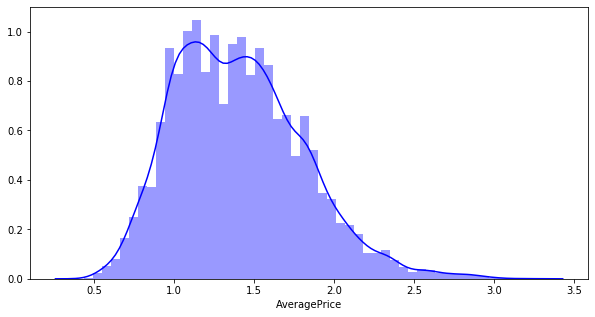

In [24]:
plt.figure(figsize = [10,5])

sns.distplot(df["AveragePrice"], color = 'blue')

# The Avocado's price are largely concentrated in the range of 0.75 - 2.0 USD per fruit

In [25]:
df_type_price = df[['type','AveragePrice']].groupby(['type']).mean().sort_values('AveragePrice',ascending = False)

df_type_price

# Observed that typically organic is costlier than conventional, forecasted the organic and conventional prices
# in the forecast section

,AveragePrice
type,
organic,1.653999
conventional,1.158040


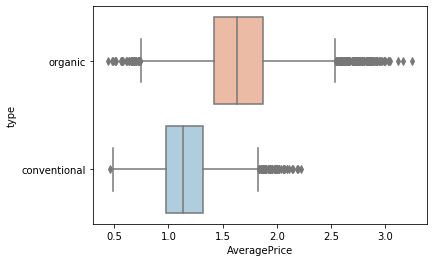

In [26]:
sns.boxplot(y=df['type'], x=df['AveragePrice'],  palette = 'RdBu')

# The mean price of organic avocado is slightly higher than 1.5 USD
# The mean price of conventional avocado is slightly higher than 1.0 USD

In [27]:
# Understandong region wise avocado prices using groupby

df_region_price = df[['region','AveragePrice','Total Volume']].groupby(['region']).mean().sort_values(
        'AveragePrice',
        ascending = False)

df_region_price.head()

# Region wise sales

,AveragePrice,Total Volume
region,,
HartfordSpringfield,1.818639,149912.832722
SanFrancisco,1.804201,401864.472722
NewYork,1.727574,712231.146538
Philadelphia,1.632130,212540.823018
Sacramento,1.621568,222377.949290


### Q-1) In which regions can millenials have their avocado toast AND buy a home?

We can see that the regions - *'HartfordSpringfield', 'SanFrancisco', 'NewYork'* has the top three avocado prices making it very costly choice for a avocado toast!

In [28]:
df['total_sales'] = df['AveragePrice'] * df['Total Volume']

df.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,total_sales
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast,47890.3075
11829,2015-01-04,1.46,612910.15,233286.13,216611.20,4370.99,158641.83,115068.71,43573.12,0.00,organic,2015,TotalUS,894848.8190
11777,2015-01-04,1.70,1885.48,748.62,30.19,0.00,1106.67,1106.67,0.00,0.00,organic,2015,Tampa,3205.3160
675,2015-01-04,0.99,668086.00,117454.09,429518.41,5553.60,115559.90,67894.33,47661.52,4.05,conventional,2015,Denver,661405.1400
1247,2015-01-04,0.92,101162.98,1991.63,75090.16,283.88,23797.31,7769.36,16027.95,0.00,conventional,2015,Louisville,93069.9416


In [29]:
df = df.sort_values('Date')
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,total_sales
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,47890.3075
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,26407.5233
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,4866.4896
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,83534.3360
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,2468.3968


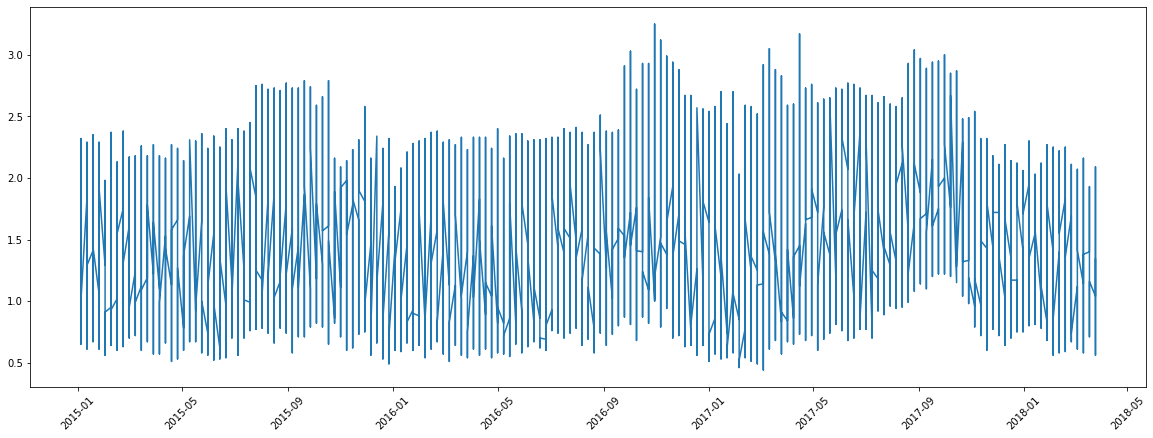

In [31]:
plt.figure(figsize = [20,7])
plt.xticks(rotation = 45 )
plt.plot(df['Date'],df['AveragePrice'])

# The resultant graph is very messy, especially near the x values along axis

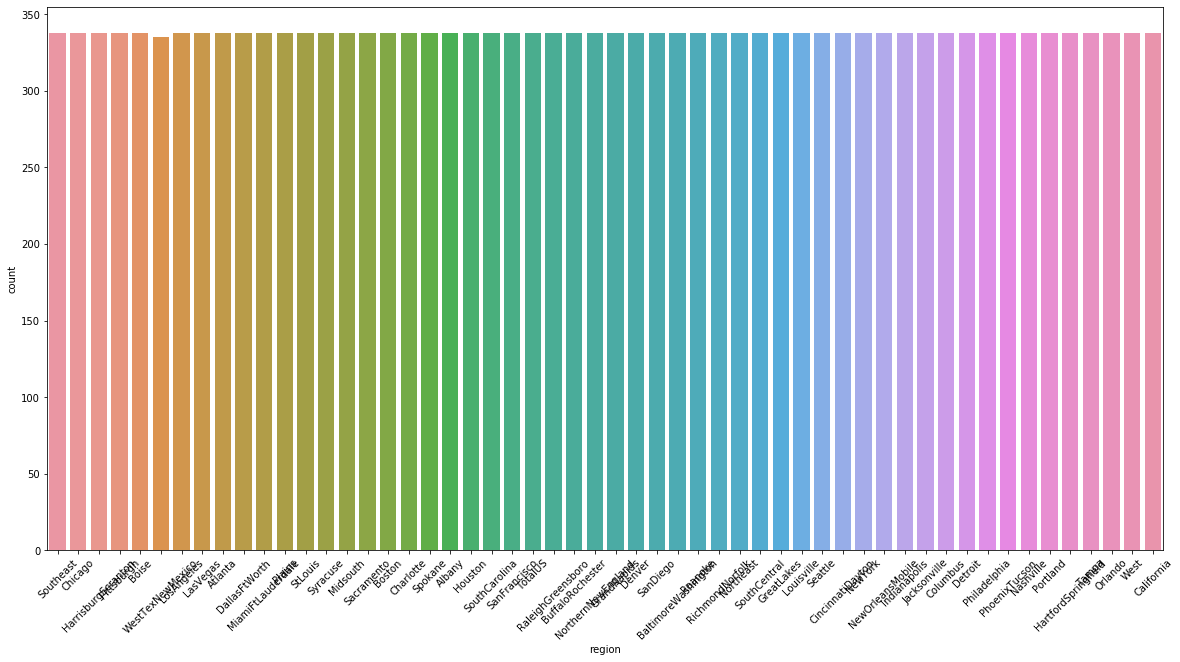

In [10]:
plt.figure(figsize = [20,10])
plt.xticks(rotation = 45 )
sns.countplot(df['region'])


# we have similiar number of datapoints for everyregion mentioned

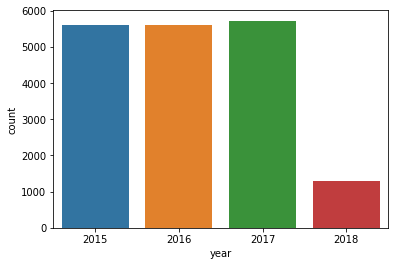

In [32]:
sns.countplot(df['year'])

# Lesser number of records from 2018 is because the data could have been extracted before completetion of 2018 FY.

In [34]:
df2 = df[['Date','AveragePrice']]

df2

,Date,AveragePrice
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64
...,...,...
8574,2018-03-25,1.36
9018,2018-03-25,0.70
17625,2018-03-25,1.33
18033,2018-03-25,1.66


## Modelling using fb prophet

In [35]:

df2 = df2.rename(columns = {'Date':'ds','AveragePrice':'y'}) # for the reason that prophet accepts only ds, y
df2.head()

,ds,y
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64


In [36]:
m = Prophet()
m.fit(df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Forecasting

In [37]:
# forecasting the future prices

future = m.make_future_dataframe(periods = 1000)

forecast = m.predict(future)


In [38]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.49881,0.910608,1.886223,1.49881,1.49881,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,0.0,0.0,0.0,1.383928
1,2015-01-04,1.49881,0.920461,1.846706,1.49881,1.49881,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,0.0,0.0,0.0,1.383928
2,2015-01-04,1.49881,0.919187,1.865240,1.49881,1.49881,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,0.0,0.0,0.0,1.383928
3,2015-01-04,1.49881,0.903529,1.889385,1.49881,1.49881,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,0.0,0.0,0.0,1.383928
4,2015-01-04,1.49881,0.884685,1.859783,1.49881,1.49881,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,-0.114882,0.0,0.0,0.0,1.383928


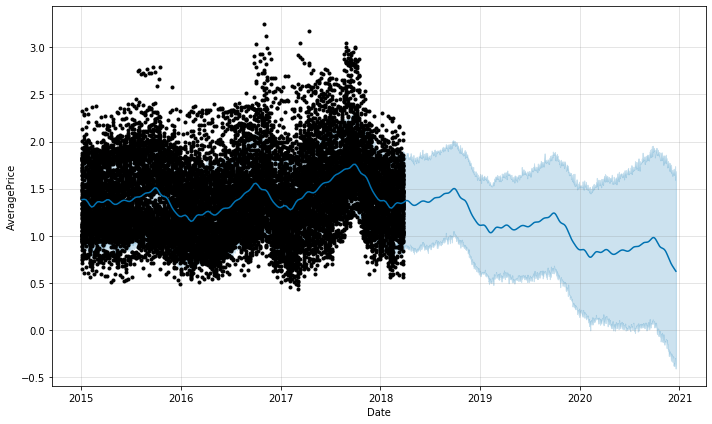

In [39]:
fig = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


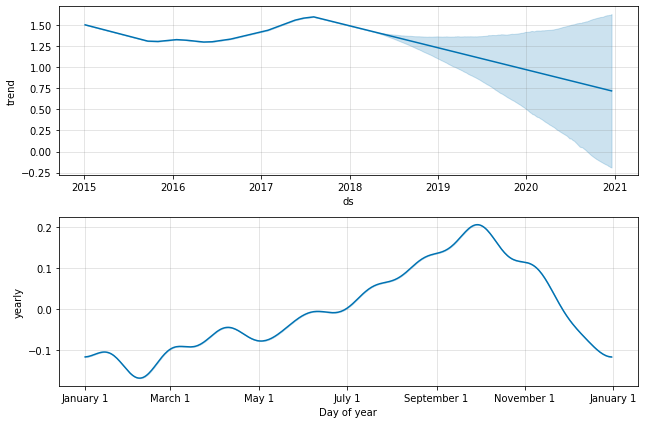

In [40]:
fig2 = m.plot_components(forecast)

In [41]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,total_sales
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,47890.3075
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,26407.5233
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,4866.4896
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,83534.3360
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,2468.3968


In [42]:
# Now we will predict prices based on region

df_sample = df[df['region']=='Chicago'][['Date','AveragePrice','region']]
df_sample.head()


,Date,AveragePrice,region
9593,2015-01-04,1.49,Chicago
467,2015-01-04,1.11,Chicago
9592,2015-01-11,1.79,Chicago
466,2015-01-11,1.15,Chicago
9591,2015-01-18,1.81,Chicago


In [43]:
df_sample_model = df_sample.drop(['region'], axis = 1)
df_sample_model = df_sample_model.rename(columns = {'Date':'ds','AveragePrice':'y'})


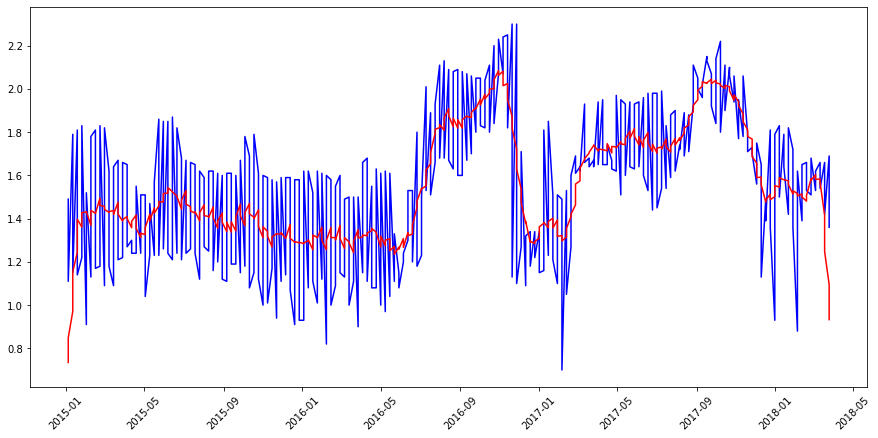

In [44]:
from __future__ import division
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy import linspace, loadtxt, ones, convolve
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


plt.figure(figsize = [15,7])

plt.xticks (rotation = 45)

# plt.plot(df_sample.Date, df_sample.AveragePrice)

# Moving average  of graph of windowsize = 10

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = df_sample.Date
y = df_sample.AveragePrice


plot(x,y,"b")
y_av = movingaverage(y, 10)
plot(x, y_av,"r")

# xlabel("Months since Jan 1749.")
# ylabel("No. of Sun spots")
show()

In [45]:
m = Prophet()
m.fit(df_sample_model)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [46]:
future = m.make_future_dataframe(periods = 500)

forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.385636,0.889432,1.573622,1.385636,1.385636,-0.171638,-0.171638,-0.171638,-0.171638,-0.171638,-0.171638,0.0,0.0,0.0,1.213998
1,2015-01-04,1.385636,0.861946,1.577965,1.385636,1.385636,-0.171638,-0.171638,-0.171638,-0.171638,-0.171638,-0.171638,0.0,0.0,0.0,1.213998
2,2015-01-11,1.386846,0.991955,1.656406,1.386846,1.386846,-0.068844,-0.068844,-0.068844,-0.068844,-0.068844,-0.068844,0.0,0.0,0.0,1.318002
3,2015-01-11,1.386846,0.961847,1.675356,1.386846,1.386846,-0.068844,-0.068844,-0.068844,-0.068844,-0.068844,-0.068844,0.0,0.0,0.0,1.318002
4,2015-01-18,1.388056,0.977900,1.667608,1.388056,1.388056,-0.062023,-0.062023,-0.062023,-0.062023,-0.062023,-0.062023,0.0,0.0,0.0,1.326033


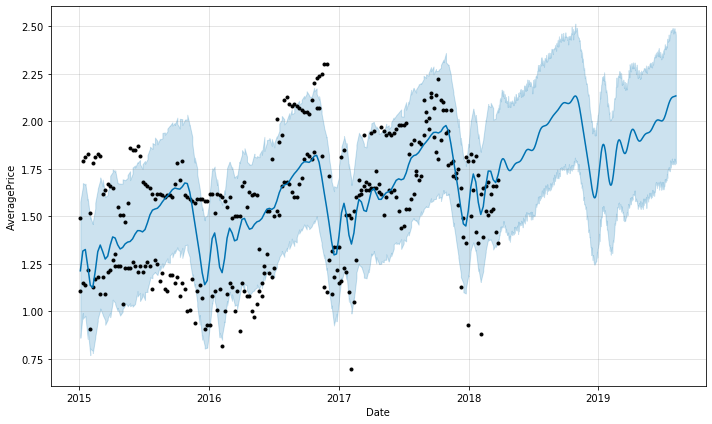

In [47]:
fig3 = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


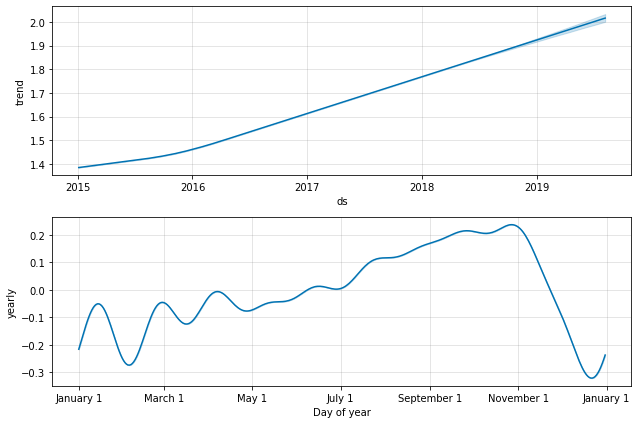

In [48]:
fig4 = m.plot_components(forecast)

# we can see that for 'Chicago' region the trend is upwards and every year the prices peak during ending
# of october month and dips to year's low during dec-jan transition time



In [49]:
# Forecasting organic avocados price for next 500 days from last date of available price

df_sample_organic = df[df['type'] == 'organic'][['AveragePrice','Date']]

df_sample_organic = df_sample_organic.rename(columns = {'Date':'ds','AveragePrice':'y'})

m = Prophet()
m.fit(df_sample_organic)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [50]:
df_sample_organic.head()

,y,ds
11569,1.75,2015-01-04
9593,1.49,2015-01-04
10009,1.68,2015-01-04
9333,1.64,2015-01-04
10269,1.50,2015-01-04


In [51]:
future = m.make_future_dataframe(periods = 500)

forecast = m.predict(future)
forecast.head()

/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.756543,1.229217,2.090654,1.756543,1.756543,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,0.0,0.0,0.0,1.641062
1,2015-01-04,1.756543,1.192367,2.066140,1.756543,1.756543,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,0.0,0.0,0.0,1.641062
2,2015-01-04,1.756543,1.176997,2.088535,1.756543,1.756543,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,0.0,0.0,0.0,1.641062
3,2015-01-04,1.756543,1.232516,2.082681,1.756543,1.756543,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,0.0,0.0,0.0,1.641062
4,2015-01-04,1.756543,1.210701,2.077256,1.756543,1.756543,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,-0.115482,0.0,0.0,0.0,1.641062


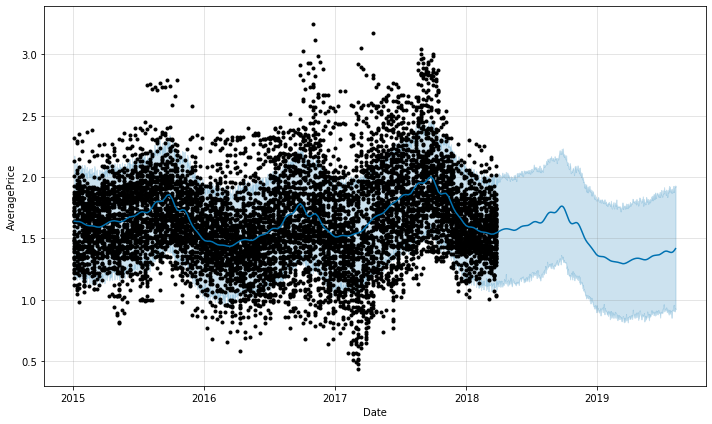

In [52]:
fig5 = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

# Organic avocados are expected to go cheaper in 2019 summer when compared to 2018 summer and even 2017 summer!

/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


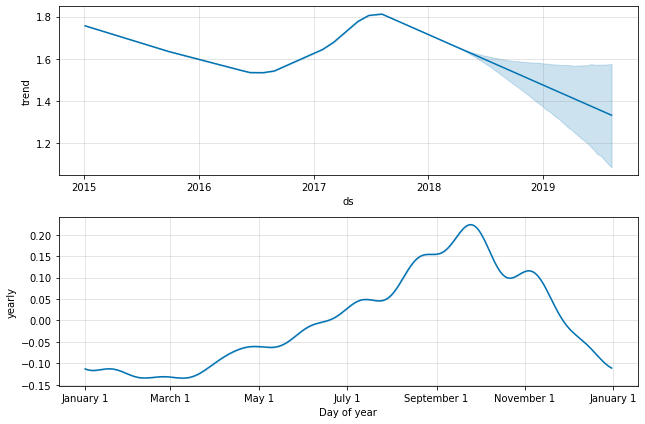

In [53]:
fig6 = m.plot_components(forecast)

# The discussed trend can be stregthened by seeing the forecast of prices and the range of organice avocados could be
# in the range of 1.1 - 1.55 USD per fruit in 2019 summer


# On a yearly basis organic avocado prices follow similiar trend of whole batch, i.e reaches peak during month of 
# October.

In [54]:
# Forecasting conventional avocados price for next 500 days from last date of available price

df_sample_cnv = df[df['type'] == 'conventional'][['AveragePrice','Date']]

df_sample_cnv = df_sample_cnv.rename(columns = {'Date':'ds','AveragePrice':'y'})

m = Prophet()
m.fit(df_sample_cnv)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [55]:
df_sample_cnv.head()

,y,ds
1819,1.52,2015-01-04
2807,0.75,2015-01-04
1195,0.85,2015-01-04
103,1.00,2015-01-04
1143,0.80,2015-01-04


In [56]:
future = m.make_future_dataframe(periods = 500)

forecast = m.predict(future)
forecast.head()

/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.220979,0.828220,1.388543,1.220979,1.220979,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,0.0,0.0,0.0,1.108513
1,2015-01-04,1.220979,0.828105,1.368851,1.220979,1.220979,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,0.0,0.0,0.0,1.108513
2,2015-01-04,1.220979,0.819748,1.384431,1.220979,1.220979,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,0.0,0.0,0.0,1.108513
3,2015-01-04,1.220979,0.839339,1.367219,1.220979,1.220979,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,0.0,0.0,0.0,1.108513
4,2015-01-04,1.220979,0.830035,1.396215,1.220979,1.220979,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,-0.112466,0.0,0.0,0.0,1.108513


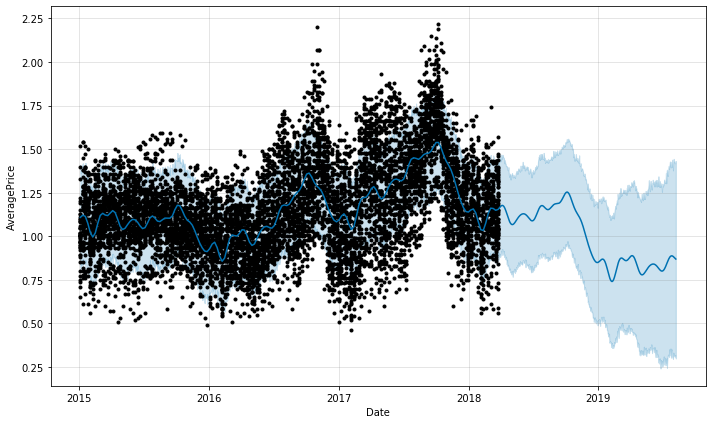

In [57]:
fig7 = m.plot(forecast, xlabel = 'Date', ylabel = 'AveragePrice')

# The trend seems similar to that of organic but as obtained conventional avocados are slightly cheaper
# It is intresting to observe that the 2019 prices of avocado seems to reach the record low from 2015 

/Users/Aneesh/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


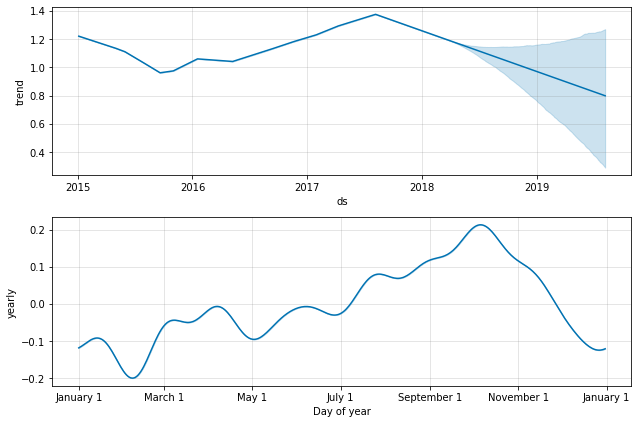

In [58]:
fig6 = m.plot_components(forecast)